# Treinamento do modelo

O treinamento do modelo envolve, primeiramente, o pré-processamento dos dados, a exploração deles e a feature engineering. Inicialmente, abrimos o arquivo como um dataframe e fazemos uma exploração inicial das colunas.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('Mall_Customers.csv')

As células abaixo trazem uma série de funções para se ter uma análise estatística do dataset, com vários gráficos para comparar as variáveis.

In [2]:
# Display basic information about the dataset
def display_basic_info(df):
    print("First few rows of the dataset:")
    print(df.head())
    print("\nSummary statistics:")
    print(df.describe())

# Create a pairplot for scatter plots and histograms
def create_pairplot(df, hue_column='Gender'):
    sns.set(style="ticks")
    sns.pairplot(df, hue=hue_column)
    plt.show()

# Create a correlation heatmap
def create_correlation_heatmap(df):
    columns_to_plot = [col for col in df.columns if col != 'Gender']
    corr = df[columns_to_plot].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title("Correlation Heatmap")
    plt.show()

def create_overlapping_histograms(df, columns_to_plot):
    plt.figure(figsize=(10, 5))
    for column_name in columns_to_plot:
        sns.histplot(data=df, x=column_name, kde=True, bins=30, label=column_name)

    plt.title("Distribution of Features")
    plt.legend()
    plt.show()
    
# Create a boxplot
def create_boxplot(df, x_column, y_column):
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=x_column, y=y_column, data=df)
    plt.title(f"{y_column} by {x_column}")
    plt.show()


Rodando a função de dados básicos, identificamos uma coluna desnecessária, a de Costumer ID. Podemos removê-la.

In [3]:
display_basic_info(df)

First few rows of the dataset:
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

Summary statistics:
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75% 

In [4]:
df.drop('CustomerID', inplace=True, axis=1)

Abaixo, criamos diversos gráficos comparando as diferentes features disponíveis. O gráfico de boxplot, em particular, nos mostra que existe uma pequena variação entre homens e mulheres no Score final; portanto, como já temos poucas colunas, torna-se interessante manter essa feature. Além disso, a baixa correlação entre as outras também justifica o mantimento das mesmas.

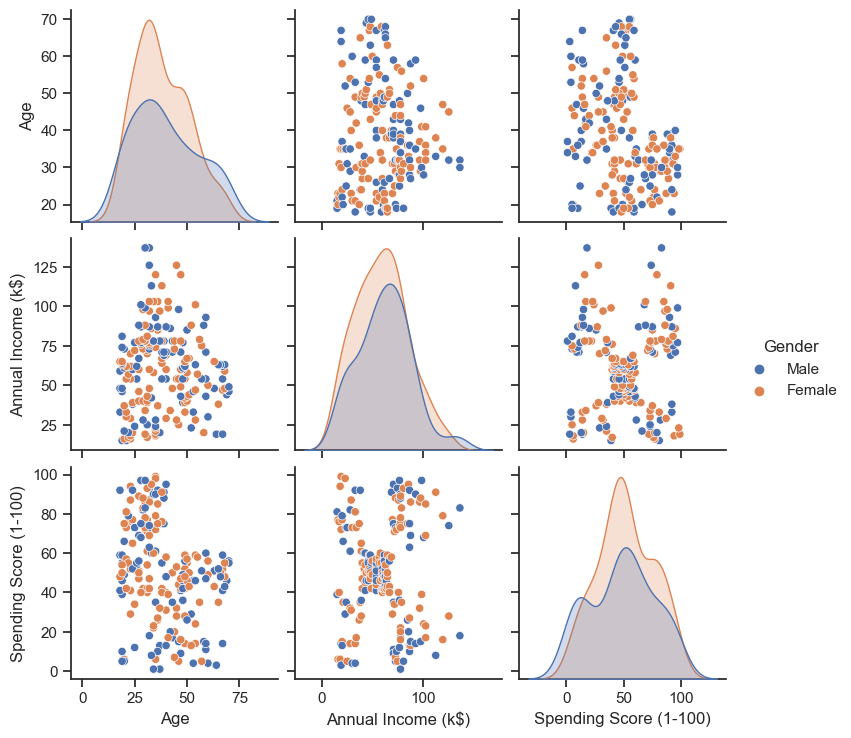

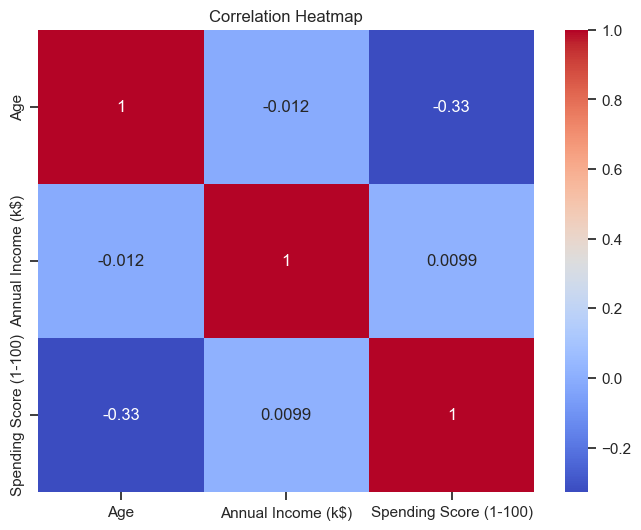

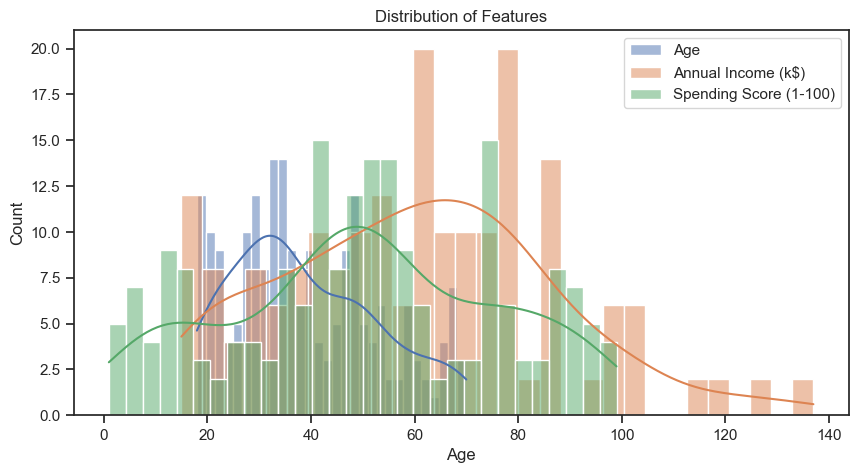

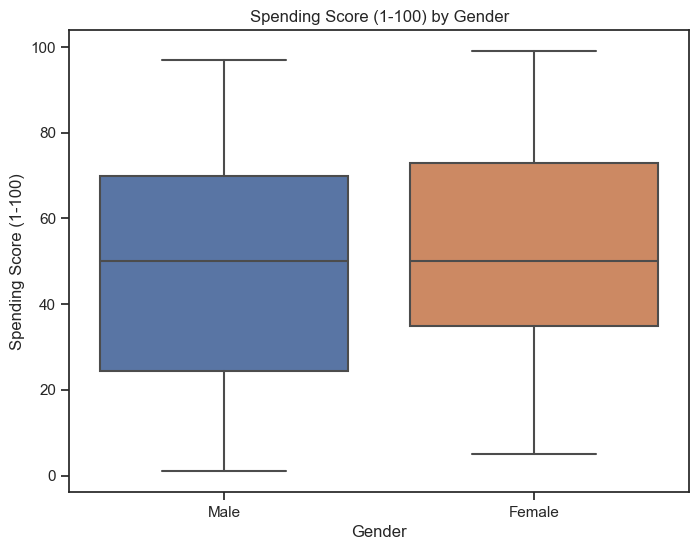

In [5]:
create_pairplot(df, hue_column='Gender')
create_correlation_heatmap(df)
columns_to_plot = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
create_overlapping_histograms(df, columns_to_plot)
create_boxplot(df, 'Gender', 'Spending Score (1-100)')

In [6]:
new_column_names = {
    'Spending Score (1-100)': 'Score',
    'Annual Income (k$)': 'Income',
}

df.rename(columns=new_column_names, inplace=True)
df.head()

,Gender,Age,Income,Score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


Fazemos o one-hot encoding das variáveis categóricas, no caso de Gênero, porque elas não possuem ordem inerente.

In [7]:
df_encoded = pd.get_dummies(df, columns=['Gender'], prefix=['Gender']).astype(int)

Normalizamos os dados para que todos estejam na mesma escala.

In [8]:
def minmax_scaling(df):
    df_normalized = df.copy()
    for column in df.columns:
        if column != 'Score':  # Exclude the 'score' column from normalization
            df_normalized[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
    return df_normalized

# Call the function to normalize the columns in your DataFrame
normalized_data = minmax_scaling(df_encoded)

In [9]:
normalized_data.head()

,Age,Income,Score,Gender_Female,Gender_Male
0,0.019231,0.000000,39,0.0,1.0
1,0.057692,0.000000,81,0.0,1.0
2,0.038462,0.008197,6,1.0,0.0
3,0.096154,0.008197,77,1.0,0.0
4,0.250000,0.016393,40,1.0,0.0


Checamos se existem valores nulos e/ou categóricos sobrando.

In [10]:
if normalized_data.isnull().values.any():
    print("There are missing (NaN) values in the DataFrame.")
else:
    print("There are no missing (NaN) values in the DataFrame.")

There are no missing (NaN) values in the DataFrame.


In [11]:
print(normalized_data.dtypes)

Age              float64
Income           float64
Score              int32
Gender_Female    float64
Gender_Male      float64
dtype: object


Começamos o treinamento de diferentes modelos. Escolhemos três regressores que costumam performar bem: RandomForest, Adaboost e KNN. A métrica para comparação é o erro médio absoluto, pois nos indica quantas unidade o modelo tende a prever acima ou abaixo do resultado real. 

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error

X = normalized_data.drop(columns=['Score'])

# 'Score' column will be your target variable (y)
y = normalized_data['Score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)
rf_predictions = rf_regressor.predict(X_test)
rf_mse = mean_absolute_error(y_test, rf_predictions)
print("Random Forest Regressor MAE:", rf_mse)

# AdaBoost Regressor
adaboost_regressor = AdaBoostRegressor(n_estimators=50, random_state=42)
adaboost_regressor.fit(X_train, y_train)
adaboost_predictions = adaboost_regressor.predict(X_test)
adaboost_mse = mean_absolute_error(y_test, adaboost_predictions)
print("AdaBoost Regressor MAE:", adaboost_mse)

# k-Nearest Neighbors (KNN) Regressor
knn_regressor = KNeighborsRegressor(n_neighbors=5)
knn_regressor.fit(X_train, y_train)
knn_predictions = knn_regressor.predict(X_test)
knn_mse = mean_absolute_error(y_test, knn_predictions)
print("K-Nearest Neighbors Regressor MAE:", knn_mse)

Random Forest Regressor MAE: 12.424125
AdaBoost Regressor MAE: 12.830661211853164
K-Nearest Neighbors Regressor MAE: 14.354999999999999


Como podemos ver, os modelos performaram de forma similar, porém o melhor deles foi o Random Forest. Vamos, portanto, salvá-lo como .pkl, para poder utilizá-lo na API.

In [13]:
import pickle 

model_filename = 'random_forest_regression_model.pkl'

# Save the trained model to a pickle file
with open(model_filename, 'wb') as file:
    pickle.dump(rf_regressor, file)

print(f"Random Forest Regression Model saved as {model_filename}")

Random Forest Regression Model saved as random_forest_regression_model.pkl
